<a href="https://colab.research.google.com/github/YoshifumiMiyagi/IP_LDL/blob/main/IP_LDL_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import early_stopping

raw = pd.read_excel('/content/drive/MyDrive/R7_2_10_DB1_miyagi.xlsx')
print(raw.shape)
raw.head()

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


(71, 33)


,カルテ番号,Birth_date,Examin_date,"Age_lessthan10_0,morethan11_1",Age_y,sex,Hight,Weight,HR,sysBP,...,BPStart_mmHg_2,BPEnd_mmHg_2,BPInterval_mmHg_2,BPStart_mmHg_3,BPEnd_mmHg_3,BPInterval_mmHg_3,Time_2,Time_3,Time_12,Time_13
0,10617571,2005-01-26,2019-07-23,1,14,male,165.0,43.0,52,119,...,108.153846,114.661538,6.507692,79.230769,85.738462,6.507692,0.122642,0.141509,0.104000,0.120000
1,10617654,2005-01-26,2017-08-31,1,12,female,155.5,54.7,39,103,...,97.024390,104.195122,7.170732,65.951220,70.731707,4.780488,0.162939,0.086262,0.097701,0.051724
2,10629916,2004-12-02,2024-12-10,1,20,male,174.4,70.4,55,148,...,137.588235,151.470588,13.882353,96.635294,111.211765,14.576471,0.189873,0.151899,0.162602,0.130081
3,10634783,2004-11-23,2019-12-26,1,15,male,170.2,80.6,73,148,...,126.045455,148.000000,21.954545,94.681818,115.068182,20.386364,0.171171,0.117117,0.193878,0.132653
4,10637737,1998-10-01,2018-08-07,1,19,female,150.0,NaN,52,108,...,101.000000,103.666667,2.666667,78.000000,79.000000,1.000000,0.038339,0.067093,0.036036,0.063063


In [ ]:
data = raw.iloc[:,3:]
data['sex'] = data['sex'].map({'male':1,'female':0})
#data['Age_day'] = data['Age_day'].fillna(0)
data['LDL'] = data['LDL']
data = data.dropna(subset=['LDL'])

In [ ]:
import re
data = data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
data.columns

Index(['Age_lessthan10_0_morethan11_1', 'Age_y', 'sex', 'Hight', 'Weight',
       'HR', 'sysBP', 'dysBP', 'aveBP', 'LDL', 'LDL_140', 'LDL_z', 'LDL_z_2_5',
       'Coeff_3', 'Coeff_2', 'Coeff_1', 'Coeff_0', 'BPStart_mmHg_1',
       'BPEnd_mmHg_1', 'BPInterval_mmHg_1', 'BPStart_mmHg_2', 'BPEnd_mmHg_2',
       'BPInterval_mmHg_2', 'BPStart_mmHg_3', 'BPEnd_mmHg_3',
       'BPInterval_mmHg_3', 'Time_2', 'Time_3', 'Time_12', 'Time_13'],
      dtype='object')

In [ ]:
# prompt: lightGBMで分類　性能を

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import early_stopping
import re

# Assuming the code you provided is already executed and 'data' DataFrame is available

# Define features (X) and target variable (y)
X = data.drop(['LDL', 'LDL_140', 'LDL_z', 'LDL_z_2_5'], axis=1)  # Replace 'CAD' with your target column name
y = data['LDL_z_2_5']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size as needed

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters for LightGBM
params = {'max_depth': 3,
    'objective': 'binary',  # For binary classification
    'metric': 'binary_logloss', # or 'auc'
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model with early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000, # Adjust as needed
    valid_sets=test_data,
    callbacks=[early_stopping(stopping_rounds=50)] # Stop if no improvement for 50 rounds
)


# Make predictions on the test set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test,y_pred_binary))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.293438
Accuracy: 0.8666666666666667
AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.78      1.00      0.88         7

    accuracy                           0.87        15
   macro avg       0.89      0.88      0.87        15
weighted avg       0.90      0.87      0.87        15

[[6 2]
 [0 7]]


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


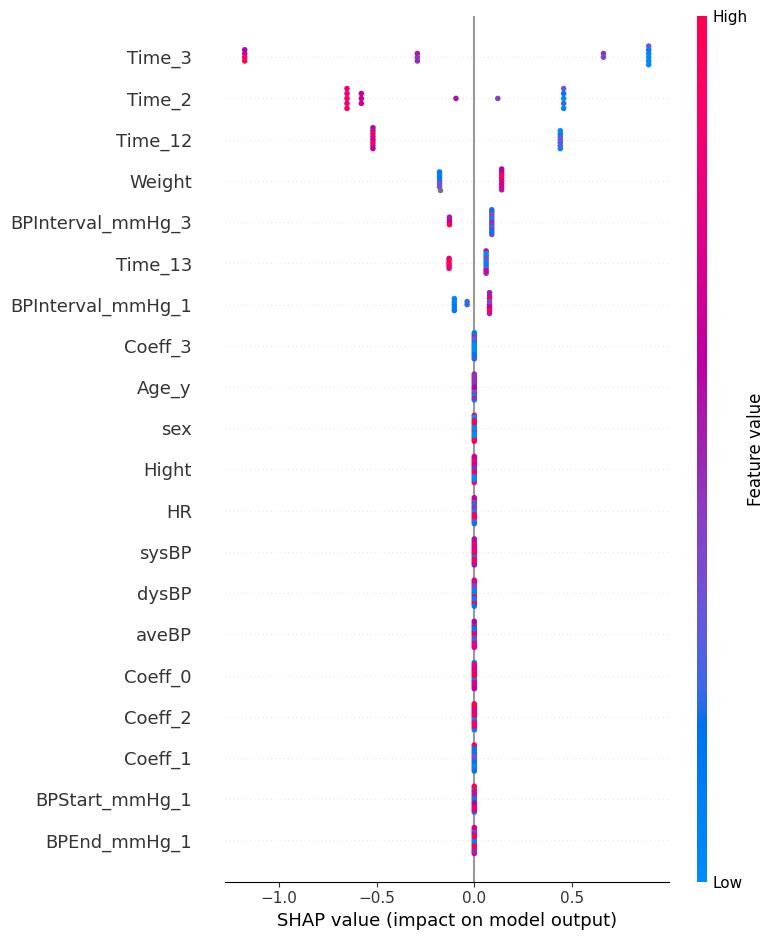

                          feature  importance
23                         Time_3    0.817801
22                         Time_2    0.500165
24                        Time_12    0.482655
4                          Weight    0.157865
21              BPInterval_mmHg_3    0.099655
25                        Time_13    0.083483
15              BPInterval_mmHg_1    0.080585
14                   BPEnd_mmHg_1    0.000000
20                   BPEnd_mmHg_3    0.000000
19                 BPStart_mmHg_3    0.000000
18              BPInterval_mmHg_2    0.000000
17                   BPEnd_mmHg_2    0.000000
16                 BPStart_mmHg_2    0.000000
0   Age_lessthan10_0_morethan11_1    0.000000
1                           Age_y    0.000000
12                        Coeff_0    0.000000
11                        Coeff_1    0.000000
10                        Coeff_2    0.000000
9                         Coeff_3    0.000000
8                           aveBP    0.000000
7                           dysBP 

In [ ]:
# prompt: SHAPで特徴量選択を

import pandas as pd
import numpy as np
import shap

# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type="dot")

# Get feature importance based on SHAP values
shap_importances = pd.DataFrame(
    {"feature": X_test.columns, "importance": np.abs(shap_values).mean(0)}
)
shap_importances = shap_importances.sort_values(by="importance", ascending=False)

print(shap_importances)

# You can use the shap_importances DataFrame to select the most important features
# For example, to keep the top 10 features:
top_10_features = shap_importances["feature"].head(7).tolist()
X_train_selected = X_train[top_10_features]
X_test_selected = X_test[top_10_features]


# Retrain your model with the selected features
# ... (code to retrain the model with X_train_selected and X_test_selected)

